## Introduction

This tutorial will introduce you to air quality forecasting. Specifically, we narrow down the range of air pollutants to fine PM, often referred to as PM2.5. Compared with weather forecasting, the first of which was the Babylonians predicted the weather from cloud patterns, air pollutant forecasting only rose up after the catastrophic [London’s Great Smog](https://en.wikipedia.org/wiki/Air_pollution_sensor). United states established its [first environmental law](https://bit.ly/2j5n2bi) regarding air pollution in 1955, and China only started to pay close attention to air pullution in a recent few years.

According to [The World Air Quality Index Project Team](http://aqicn.org/forecast/models/), numerous atmospheric models are used across the globe to predict air quality. These models are typically running in supercomputers, requiring involvement of numerous sources of data. **We are not going to use these.**

Instead, we are taking a more data-scientific approach. We will **build an artificial neural networks to predict air pollutant level with historical data.** Forecasting with historical data can actually be done with many existing models such as [Simple moving average](https://en.wikipedia.org/wiki/Moving_average#Simple_moving_average), [Exponential smoothing](https://en.wikipedia.org/wiki/Exponential_smoothing), and etc. But I am taking this chance to have a glimpse of artificial neural networks.

### Tutorial content

In this tutorial, we will show how to do air pollution forecasting in Python, specifically using [tensorflow](https://github.com/tensorflow/tensorflow), [scikit-learn](http://scikit-learn.org/stable/), [numpy](http://www.numpy.org/), and [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/).

We'll be using data collected from [United States Environmental Protection Agency (USEPA)](https://www.epa.gov/outdoor-air-quality-data/download-daily-data). The agency has a tremendous amount of historical data of major geographic areas open to the public and there seems to be no access limit. However, we won't be conducting forecast for all the areas. Instead, **we only target Pittsburgh**. It is worth noticing that this pittsburgh is not confined to the one CMU is located. Actually, it refers to the [Greater Pittsburgh Region](https://en.wikipedia.org/wiki/Greater_Pittsburgh_Region). To be frankly, this is the first time I heard of this name, but you will see later in this tutorial why we don't just focus on Pittsburgh.

We will cover the following topics in this tutorial:

1. Installing the libraries
2. Fetching data && Setting up dataframes
3. Data cleaning
4. Deriving the Features
5. Building artificial neural network

### Installing the libraries

Before getting started, you'll need to install the various libraries that we will use. Sicne I am assuming readers of this tutorial are students taking 15-388 or 15-688, who should have a proper [Anaconda](https://www.anaconda.com/download/?lang=en-us#macos) setup, scikit-learn, numpy, and BeautifulSoup should be handy. The only trouble is tensorflow.

Tensorflow comes with a default distribution. You can install it using virtualenv, conda, pip, and so on. [Just type a line of command](https://www.tensorflow.org/install/) and you are ready to go.

But the default distribution is not optimized for your local machines. Specifically, it comes with no support for CPU extensions, such as SSE4.1, SSE4.2, AVX, AVX2, FMA, etc. Neither does it support GPU (OpenCL, CUDA, and etc.). When you run a sample program of tensorflow with this default distribution, you will get warning like below:

> Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX AVX2

So the best way to install tensorflow so that your model traning doesn't take forever is to build it from source. For your convenience, please reference this [official page](https://www.tensorflow.org/install/install_sources). However, for reading fluency, you can just use the default distribution since we are not using a very large dataset.

> pip install tensorflow

And then we import all the libraries that we will use 

In [24]:
import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import requests
from bs4 import BeautifulSoup as Soup

import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score, mean_absolute_error, median_absolute_error
from sklearn.model_selection import train_test_split

### Fetching data && Setting up dataframes

USEPA doesn't expose APIs. Instead, it uses a request form to provide access. However, we can still fetch data programmatically by faking requests. Here, we will utilize [requests](http://docs.python-requests.org/en/master/) to make HTTP requests, and the ability of [pandas.read_csv](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) to load online csv files into a dataframe. The pattern of all the urls are easy to recognize, so do your own favor if you are really curious. We sleep for 2.0 to 5.0 seconds after each request in case our IP gets banned.

Historical data of Pittsburgh is available from 1999 to 2018. In our tutorial, we will cover data from 1999 to 2017.

In [25]:
dfs = []
column_names = [
    'Date', 'AQS_SITE_ID', 'POC', 'Daily Mean PM2.5 Concentration', 'UNITS',
    'DAILY_AQI_VALUE', 'DAILY_OBS_COUNT', 'PERCENT_COMPLETE',
    'AQS_PARAMETER_CODE', 'AQS_PARAMETER_DESC', 'CBSA_CODE', 'CBSA_NAME',
    'STATE_CODE', 'STATE', 'COUNTY_CODE', 'COUNTY', 'SITE_LATITUDE',
    'SITE_LONGITUDE'
]
base_url = "https://www3.epa.gov/cgi-bin/broker?_service=data&_debug=0&_program=dataprog.ad_data_daily.sas&querytext=&areaname=&areacontacts=&areasearchurl=&typeofsearch=epa&result_template=2col.ftl&poll=88101%27%2C%2788502&year={}&state=-1&cbsa=38300&county=-1&site=-1"
for year in range(1999, 2018):
    full_url = base_url.format(str(year))
    r = requests.get(full_url)
    #  the csv link is in response content
    html = Soup(r.text, 'html.parser')
    anchor = html.find('a')
    csv_link = anchor['href']
    dfs.append(pd.read_csv(csv_link, names=column_names, skiprows=1))
    time.sleep(random.uniform(2.0, 5.0))

# concat more efficient than appending one by one
df = pd.concat(dfs)

Now that we have all the historical data in the pandas dataframe. Let's take a glimpse of what the data looks like.

In [26]:
df.head(5)

,Date,AQS_SITE_ID,POC,Daily Mean PM2.5 Concentration,UNITS,DAILY_AQI_VALUE,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
0,02/23/1999,420030008,1,10.9,ug/m3 LC,45,1,100.0,88101,PM2.5 - Local Conditions,38300,"Pittsburgh, PA",42,Pennsylvania,3,Allegheny,40.46542,-79.960757
1,03/02/1999,420030008,1,11.0,ug/m3 LC,46,1,100.0,88101,PM2.5 - Local Conditions,38300,"Pittsburgh, PA",42,Pennsylvania,3,Allegheny,40.46542,-79.960757
2,03/04/1999,420030008,1,9.2,ug/m3 LC,38,1,100.0,88101,PM2.5 - Local Conditions,38300,"Pittsburgh, PA",42,Pennsylvania,3,Allegheny,40.46542,-79.960757
3,03/07/1999,420030008,1,5.4,ug/m3 LC,23,1,100.0,88101,PM2.5 - Local Conditions,38300,"Pittsburgh, PA",42,Pennsylvania,3,Allegheny,40.46542,-79.960757
4,03/10/1999,420030008,1,10.3,ug/m3 LC,43,1,100.0,88101,PM2.5 - Local Conditions,38300,"Pittsburgh, PA",42,Pennsylvania,3,Allegheny,40.46542,-79.960757


### Data cleaning

In order to conduct numerical analysis, we have to ensure that we are dealing with the right type of data. First, let us get a concise summary of the DataFrame:

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75413 entries, 0 to 6053
Data columns (total 18 columns):
Date                              75413 non-null object
AQS_SITE_ID                       75413 non-null int64
POC                               75413 non-null int64
Daily Mean PM2.5 Concentration    75413 non-null float64
UNITS                             75413 non-null object
DAILY_AQI_VALUE                   75413 non-null int64
DAILY_OBS_COUNT                   75413 non-null int64
PERCENT_COMPLETE                  75413 non-null float64
AQS_PARAMETER_CODE                75413 non-null int64
AQS_PARAMETER_DESC                75413 non-null object
CBSA_CODE                         75413 non-null int64
CBSA_NAME                         75413 non-null object
STATE_CODE                        75413 non-null int64
STATE                             75413 non-null object
COUNTY_CODE                       75413 non-null int64
COUNTY                            75413 non-null object
SI

As can be seen, the data type for a few columns is not correct. For example, Date should be of data type datetime and DAILY_AQI_VALUE should also be float64. It is obvious that some columns have wrong data types, e.g. UNITS and AQS_PARAMETER_DESC. But you will see soon enough that we don't need them in our model so we don't have to bother processing them.

In [28]:
df['Date'] = pd.to_datetime(df['Date'])
df[['DAILY_AQI_VALUE']] = df[['DAILY_AQI_VALUE']].astype(float)

Let us get an updated summary of the DataFrame:

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75413 entries, 0 to 6053
Data columns (total 18 columns):
Date                              75413 non-null datetime64[ns]
AQS_SITE_ID                       75413 non-null int64
POC                               75413 non-null int64
Daily Mean PM2.5 Concentration    75413 non-null float64
UNITS                             75413 non-null object
DAILY_AQI_VALUE                   75413 non-null float64
DAILY_OBS_COUNT                   75413 non-null int64
PERCENT_COMPLETE                  75413 non-null float64
AQS_PARAMETER_CODE                75413 non-null int64
AQS_PARAMETER_DESC                75413 non-null object
CBSA_CODE                         75413 non-null int64
CBSA_NAME                         75413 non-null object
STATE_CODE                        75413 non-null int64
STATE                             75413 non-null object
COUNTY_CODE                       75413 non-null int64
COUNTY                            75413 non-null

### Deriving the Features

Although USEPA doesn't provide a dictionary for the meaning of these columns, we can take a guess after skimming over several thousand lines of rows in the dataframe, and analyzing the unique values of each column. We select a few features (columns of the dataframe) to be used in our models.

1. Daily Mean PM2.5 Concentration
2. DAILY_AQI_VALUE

Specifically, we will be **using data on the prior three days** for the above features. For example, the row of date 03/07/1999 should have the Daily Mean PM2.5 Concentration and DAILY_AQI_VALUE of 03/06/1999, 03/05/1999, and 03/04/1999.

However, as can be seen from the above head(5) result, the two dates of adjacent lines may not be contiguous. For example, 03/03/1999 is missing between 03/02/1999 and 03/04/1999. Is the data of 03/03/1999 missing in the dataset? It turns out it is not. Actually, when we observe the data, we discover that the data of 03/03/1999 is recorded by a couple other sensors (as identified by AQS_SITE_ID).



In [30]:
df.loc[df['Date'] == np.datetime64("1999-03-03")]

,Date,AQS_SITE_ID,POC,Daily Mean PM2.5 Concentration,UNITS,DAILY_AQI_VALUE,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
178,1999-03-03,420030064,1,9.7,ug/m3 LC,40.0,1,100.0,88101,PM2.5 - Local Conditions,38300,"Pittsburgh, PA",42,Pennsylvania,3,Allegheny,40.323768,-79.868062
957,1999-03-03,421255001,1,7.5,ug/m3 LC,31.0,1,100.0,88101,PM2.5 - Local Conditions,38300,"Pittsburgh, PA",42,Pennsylvania,125,Washington,40.445278,-80.420833


So this poses a challenge to us: we can't just shift the data in the feature columns to build the columns of prior three days. Instead, we will have to explicity look up the row of 03/03/1999 when we are, for example, dealing with the prior three days of 03/05/1999 (which is unfortunately also missing in the head(5) result).

Can't we just sort the data according to the Date column so that we can just shift the column to get the data of prior three days we want? Let's see if it works out:

In [31]:
df = df.sort_values(by=['Date'])
df.head(20)

,Date,AQS_SITE_ID,POC,Daily Mean PM2.5 Concentration,UNITS,DAILY_AQI_VALUE,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
942,1999-01-08,421255001,1,14.5,ug/m3 LC,56.0,1,100.0,88101,PM2.5 - Local Conditions,38300,"Pittsburgh, PA",42,Pennsylvania,125,Washington,40.445278,-80.420833
943,1999-01-09,421255001,1,9.4,ug/m3 LC,39.0,1,100.0,88101,PM2.5 - Local Conditions,38300,"Pittsburgh, PA",42,Pennsylvania,125,Washington,40.445278,-80.420833
944,1999-01-10,421255001,1,11.6,ug/m3 LC,48.0,1,100.0,88101,PM2.5 - Local Conditions,38300,"Pittsburgh, PA",42,Pennsylvania,125,Washington,40.445278,-80.420833
792,1999-01-15,421250005,1,15.4,ug/m3 LC,58.0,1,100.0,88101,PM2.5 - Local Conditions,38300,"Pittsburgh, PA",42,Pennsylvania,125,Washington,40.146667,-79.902222
865,1999-01-18,421250200,1,5.0,ug/m3 LC,21.0,1,100.0,88101,PM2.5 - Local Conditions,38300,"Pittsburgh, PA",42,Pennsylvania,125,Washington,40.170556,-80.261389
157,1999-01-23,420030064,1,13.3,ug/m3 LC,54.0,1,100.0,88101,PM2.5 - Local Conditions,38300,"Pittsburgh, PA",42,Pennsylvania,3,Allegheny,40.323768,-79.868062
749,1999-01-24,420039002,1,9.6,ug/m3 LC,40.0,1,100.0,88101,PM2.5 - Local Conditions,38300,"Pittsburgh, PA",42,Pennsylvania,3,Allegheny,40.547011,-79.783660
793,1999-01-24,421250005,1,9.1,ug/m3 LC,38.0,1,100.0,88101,PM2.5 - Local Conditions,38300,"Pittsburgh, PA",42,Pennsylvania,125,Washington,40.146667,-79.902222
158,1999-01-24,420030064,1,10.0,ug/m3 LC,42.0,1,100.0,88101,PM2.5 - Local Conditions,38300,"Pittsburgh, PA",42,Pennsylvania,3,Allegheny,40.323768,-79.868062
866,1999-01-24,421250200,1,8.5,ug/m3 LC,35.0,1,100.0,88101,PM2.5 - Local Conditions,38300,"Pittsburgh, PA",42,Pennsylvania,125,Washington,40.170556,-80.261389


It turns out that the sorting makes the data a little bit easier to work with. For example, if you want to get the data of prior three days of 1999-01-27, you can get them in the previous three rows.

But several new problems arise. 

First of all, we now have different measurements of the same date in adjacent rows. If we just shift the column, we won't get the data of prior three days. This situation is due to that different sensors may take maesurements from different places (in Greater Pittsburgh Region) on the same date. For exmaple, as you can see above, the two measurements of 1999-01-27 comes from two different sensors. 

In [32]:
df.loc[df['Date'] == np.datetime64("1999-01-27")]

,Date,AQS_SITE_ID,POC,Daily Mean PM2.5 Concentration,UNITS,DAILY_AQI_VALUE,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
867,1999-01-27,421250200,1,21.6,ug/m3 LC,71.0,1,100.0,88101,PM2.5 - Local Conditions,38300,"Pittsburgh, PA",42,Pennsylvania,125,Washington,40.170556,-80.261389
794,1999-01-27,421250005,1,22.7,ug/m3 LC,73.0,1,100.0,88101,PM2.5 - Local Conditions,38300,"Pittsburgh, PA",42,Pennsylvania,125,Washington,40.146667,-79.902222


Since we only care about the average air pullutant of the whole area, we can simply reduce these two rows into one, averaging their measurements. The same can be applied to other dates as well. Here, we use the pandas.DataFrame.groupby method.

In [33]:
df = df.groupby('Date').mean()
df.head(20)

,AQS_SITE_ID,POC,Daily Mean PM2.5 Concentration,DAILY_AQI_VALUE,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,CBSA_CODE,STATE_CODE,COUNTY_CODE,SITE_LATITUDE,SITE_LONGITUDE
Date,,,,,,,,,,,,
1999-01-08,4.212550e+08,1.0,14.500000,56.000000,1.0,100.0,88101.0,38300.0,42.0,125.0,40.445278,-80.420833
1999-01-09,4.212550e+08,1.0,9.400000,39.000000,1.0,100.0,88101.0,38300.0,42.0,125.0,40.445278,-80.420833
1999-01-10,4.212550e+08,1.0,11.600000,48.000000,1.0,100.0,88101.0,38300.0,42.0,125.0,40.445278,-80.420833
1999-01-15,4.212500e+08,1.0,15.400000,58.000000,1.0,100.0,88101.0,38300.0,42.0,125.0,40.146667,-79.902222
1999-01-18,4.212502e+08,1.0,5.000000,21.000000,1.0,100.0,88101.0,38300.0,42.0,125.0,40.170556,-80.261389
1999-01-23,4.200301e+08,1.0,13.300000,54.000000,1.0,100.0,88101.0,38300.0,42.0,3.0,40.323768,-79.868062
1999-01-24,4.206423e+08,1.0,9.300000,38.750000,1.0,100.0,88101.0,38300.0,42.0,64.0,40.297000,-79.953833
1999-01-25,4.200301e+08,1.0,15.000000,57.000000,1.0,100.0,88101.0,38300.0,42.0,3.0,40.323768,-79.868062
1999-01-26,4.200301e+08,1.0,14.800000,57.000000,1.0,100.0,88101.0,38300.0,42.0,3.0,40.323768,-79.868062


You may notice that we have messed up the values of some columns. For example, the AQS_SITE_ID of 1999-01-10 now becomes 421255001.0, which represents a sensor that doesn't exist. But as you will see soon enough, these 'misbehaving' columns will be discarded in the end. So don't worry.

Let's come back to the problems that arose. Another problem that arises is that some dates are still missing. That is, on some date, measurements are not taken by any sensor at all. For example, on 1999-01-28, nothing is recorded. We can solve this by faking the data of these missing dates. For example, for 1999-01-28, we can simply fake its DAILY_AQI_VALUE to be 72.000000, which is the DAILY_AQI_VALUE of 1999-01-27.

In [34]:
idx = pd.date_range('01.08.1999', '12.31.2017')
df.index = pd.DatetimeIndex(df.index)
df = df.reindex(idx, method="nearest")

In [35]:
df.head(20)

,AQS_SITE_ID,POC,Daily Mean PM2.5 Concentration,DAILY_AQI_VALUE,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,CBSA_CODE,STATE_CODE,COUNTY_CODE,SITE_LATITUDE,SITE_LONGITUDE
1999-01-08,4.212550e+08,1.0,14.50,56.00,1.0,100.0,88101.0,38300.0,42.0,125.0,40.445278,-80.420833
1999-01-09,4.212550e+08,1.0,9.40,39.00,1.0,100.0,88101.0,38300.0,42.0,125.0,40.445278,-80.420833
1999-01-10,4.212550e+08,1.0,11.60,48.00,1.0,100.0,88101.0,38300.0,42.0,125.0,40.445278,-80.420833
1999-01-11,4.212550e+08,1.0,11.60,48.00,1.0,100.0,88101.0,38300.0,42.0,125.0,40.445278,-80.420833
1999-01-12,4.212550e+08,1.0,11.60,48.00,1.0,100.0,88101.0,38300.0,42.0,125.0,40.445278,-80.420833
1999-01-13,4.212500e+08,1.0,15.40,58.00,1.0,100.0,88101.0,38300.0,42.0,125.0,40.146667,-79.902222
1999-01-14,4.212500e+08,1.0,15.40,58.00,1.0,100.0,88101.0,38300.0,42.0,125.0,40.146667,-79.902222
1999-01-15,4.212500e+08,1.0,15.40,58.00,1.0,100.0,88101.0,38300.0,42.0,125.0,40.146667,-79.902222
1999-01-16,4.212500e+08,1.0,15.40,58.00,1.0,100.0,88101.0,38300.0,42.0,125.0,40.146667,-79.902222
1999-01-17,4.212502e+08,1.0,5.00,21.00,1.0,100.0,88101.0,38300.0,42.0,125.0,40.170556,-80.261389


Now can finally build the history columns with ease:

In [36]:
features = ['Daily Mean PM2.5 Concentration', 'DAILY_AQI_VALUE']
df = df[features]


def derive_nth_day_feature(df, feature, N):
    rows = df.shape[0]
    nth_prior_measurements = [None] * N + [
        df[feature][i - N] for i in range(N, rows)
    ]
    col_name = "{}_{}".format(feature, N)
    df[col_name] = nth_prior_measurements


for feature in features:
    for N in range(1, 4):
        derive_nth_day_feature(df, feature, N)

df.head(5)

,Daily Mean PM2.5 Concentration,DAILY_AQI_VALUE,Daily Mean PM2.5 Concentration_1,Daily Mean PM2.5 Concentration_2,Daily Mean PM2.5 Concentration_3,DAILY_AQI_VALUE_1,DAILY_AQI_VALUE_2,DAILY_AQI_VALUE_3
1999-01-08,14.5,56.0,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-09,9.4,39.0,14.5,NaN,NaN,56.0,NaN,NaN
1999-01-10,11.6,48.0,9.4,14.5,NaN,39.0,56.0,NaN
1999-01-11,11.6,48.0,11.6,9.4,14.5,48.0,39.0,56.0
1999-01-12,11.6,48.0,11.6,11.6,9.4,48.0,48.0,39.0


Now that we notice that the first few rows have missing values. This is due to the earliest date of our data is 1999-01-08 so that we can't have the missing data. We can simply remove thses rows. We can then call the dropna method to drop the rows containing missing values. And then let's make a final look at our data before we start to build the  artificial neural network.

In [37]:
df = df.dropna()
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6930 entries, 0 to 6929
Data columns (total 8 columns):
Daily Mean PM2.5 Concentration      6930 non-null float64
DAILY_AQI_VALUE                     6930 non-null float64
Daily Mean PM2.5 Concentration_1    6930 non-null float64
Daily Mean PM2.5 Concentration_2    6930 non-null float64
Daily Mean PM2.5 Concentration_3    6930 non-null float64
DAILY_AQI_VALUE_1                   6930 non-null float64
DAILY_AQI_VALUE_2                   6930 non-null float64
DAILY_AQI_VALUE_3                   6930 non-null float64
dtypes: float64(8)
memory usage: 433.2 KB


### Building artificial neural network

One very strong tool that we used in this data science course is linear regression. The most basic assumption behind linear regression is the linear relationships between the dependent variables and the independent variables. However, linearity is not the nature of many phenomenon. In recent years, one heated technique that tries to overcome this un-comprehensive assumption is neural network, which is now used frequently for both linear and non-linear relationships between dependent variables and the independent variables.

However, I am not going to go over the theory of artificial neural network. I will simply walk you through how we can **use** artificial neural network to solve our problem.

The below operation change the column names of the dataframe so that the data can be accepted by tensorflow.

In [38]:
# need to conform to tensorflow scope name constraints
df.columns = [
    'PM2_5', 'DAILY_AQI_VALUE', 'PM2_5_1', 'PM2_5_2', 'PM2_5_3',
    'DAILY_AQI_VALUE_1', 'DAILY_AQI_VALUE_2', 'DAILY_AQI_VALUE_3'
]

The next thing we want to do is to separate the targets (y, the actual mean PM2.5) and the features (X, the other columns).

In [39]:
X = df[[col for col in df.columns if col != 'PM2_5']]
y = df['PM2_5']

In [40]:
X.columns

Index(['DAILY_AQI_VALUE', 'PM2_5_1', 'PM2_5_2', 'PM2_5_3', 'DAILY_AQI_VALUE_1',
       'DAILY_AQI_VALUE_2', 'DAILY_AQI_VALUE_3'],
      dtype='object')

While building a neural network, we typically do the following:

1. **Training phase**: we feed data with input with expected output into the model
2. **Evalidation phase**: this accompanies each training phase. It feed some data into the half-trained model, evaluating its generated output the the expected output, showing real-time progress of the model training (possibly using matplotlib)
3. **Test phase**: After the model (good or bad) is fully trained, we input some existing data into the model to get some statistical understanding of the model

Here, we separate our existing dataframe so that 80% becomes training data, 10% becomes evalidation data, and 10% becomes testing data.

The random_state=123/456 parameter is just the seed for the underlying random number generator. This helps avoid that the data of different characteristics (date, etc.) in the original dataset is not spread evenly in the two new datasets.

In [41]:
X_train, X_eva_test, y_train, y_eva_test = train_test_split(
    X, y, test_size=0.2, random_state=123)
X_eva, X_test, y_eva, y_test = train_test_split(
    X_eva_test, y_eva_test, test_size=0.5, random_state=456)

We can see that the three datasets are indeed 80:10:10

In [42]:
print(X_train.shape)
print(X_eva.shape)
print(X_test.shape)

(5544, 7)
(693, 7)
(693, 7)


In order for our features columns to be eligible for input into the training model, we have to tranform them into so-callde feature_columns, as requested by tensorflow. All our input features are numeric, so use numeric_column for each one.

In [43]:
feature_cols = [tf.feature_column.numeric_column(col) for col in X.columns]

When building our neural network, instead of using the low-level APIs of tensorflow, namely the Core API, we will use a higher level API called DNNRegressor. So instead of defining placeholders, variable, constants, and etc. on our own, we take advantage of an existing model which has proven to be powerful enough for our case.

Here, we use two hidden layers, each with 30 nodes. There is no rule of thumb for the number of hidden layers and the number of nodes within them, but it turns out that I get pretty good result with this setting ;)

In [44]:
regressor = tf.estimator.DNNRegressor(
    feature_columns=feature_cols,
    hidden_units=[30, 30],
    model_dir='tf_wx_model')


def input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=400):
    return tf.estimator.inputs.pandas_input_fn(
        x=X,
        y=y,
        num_epochs=num_epochs,
        shuffle=shuffle,
        batch_size=batch_size)


real_time_evaluations = []
STEPS = 400
for i in range(100):
    regressor.train(input_fn=input_fn(X_train, y=y_train), steps=STEPS)
    real_time_evaluations.append(
        regressor.evaluate(
            input_fn=input_fn(X_test, y_test, num_epochs=1, shuffle=False)))


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tf_wx_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a254df940>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into tf_wx_model/model.ckpt.
INFO:tensorflow:loss = 210937.0, step = 1
INFO:tensorflow:global_st

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-30-04:06:53
INFO:tensorflow:Saving dict for global step 2400: average_loss = 0.527144, global_step = 2400, loss = 182.655
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-2400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2401 into tf_wx_model/model.ckpt.
INFO:tensorflow:loss = 209.574, step = 2401
INFO:tensorflow:global_step/sec: 121.082
INFO:tensorflow:loss = 243.387, step = 2501 (0.833 sec)
INFO:tensorflow:global_step/sec: 180.186
INFO:tensorflow:loss = 136.989, step = 2601 (0.553 sec)
INFO:tensorflow:global_step/sec: 167.843
INFO:tensorflow:loss = 218.401, step = 2701 (0.598 sec)
INFO:tensorflow:Saving checkpoint

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-4800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 4801 into tf_wx_model/model.ckpt.
INFO:tensorflow:loss = 124.796, step = 4801
INFO:tensorflow:global_step/sec: 119.218
INFO:tensorflow:loss = 238.965, step = 4901 (0.843 sec)
INFO:tensorflow:global_step/sec: 183.521
INFO:tensorflow:loss = 255.343, step = 5001 (0.547 sec)
INFO:tensorflow:global_step/sec: 157.09
INFO:tensorflow:loss = 93.8544, step = 5101 (0.635 sec)
INFO:tensorflow:Saving checkpoints for 5200 into tf_wx_model/model.ckpt.
INFO:tensorflow:Loss for final step: 119.638.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-30-04:07:24
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parame

INFO:tensorflow:Saving checkpoints for 7201 into tf_wx_model/model.ckpt.
INFO:tensorflow:loss = 107.124, step = 7201
INFO:tensorflow:global_step/sec: 159.11
INFO:tensorflow:loss = 150.529, step = 7301 (0.633 sec)
INFO:tensorflow:global_step/sec: 147.702
INFO:tensorflow:loss = 158.609, step = 7401 (0.677 sec)
INFO:tensorflow:global_step/sec: 154.154
INFO:tensorflow:loss = 94.6768, step = 7501 (0.650 sec)
INFO:tensorflow:Saving checkpoints for 7600 into tf_wx_model/model.ckpt.
INFO:tensorflow:Loss for final step: 113.523.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-30-04:07:50
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-7600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-30-04:07:50
INFO:tensorflow:Saving dict for global step 7600: average_loss = 0.369583, global_step = 7600

INFO:tensorflow:global_step/sec: 177.342
INFO:tensorflow:loss = 226.559, step = 9901 (0.564 sec)
INFO:tensorflow:Saving checkpoints for 10000 into tf_wx_model/model.ckpt.
INFO:tensorflow:Loss for final step: 89.9389.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-30-04:08:17
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-30-04:08:18
INFO:tensorflow:Saving dict for global step 10000: average_loss = 0.357435, global_step = 10000, loss = 123.851
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done runn

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-30-04:08:43
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-12400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-30-04:08:43
INFO:tensorflow:Saving dict for global step 12400: average_loss = 0.34955, global_step = 12400, loss = 121.119
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-12400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 12401 into tf_wx_model/model.ckpt.
INFO:tensorflow:loss = 77.6211, step = 12401
INFO:tensorflow:global_step/sec: 128.246
INFO:tensorflow:loss = 71.5561, step = 

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-30-04:09:09
INFO:tensorflow:Saving dict for global step 14800: average_loss = 0.339416, global_step = 14800, loss = 117.608
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-14800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 14801 into tf_wx_model/model.ckpt.
INFO:tensorflow:loss = 150.567, step = 14801
INFO:tensorflow:global_step/sec: 162.137
INFO:tensorflow:loss = 157.81, step = 14901 (0.621 sec)
INFO:tensorflow:global_step/sec: 185.444
INFO:tensorflow:loss = 178.229, step = 15001 (0.540 sec)
INFO:tensorflow:global_step/sec: 142.476
INFO:tensorflow:loss = 97.7676, step = 15101 (0.700 sec)
INFO:tensorflow:Saving che

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-17200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 17201 into tf_wx_model/model.ckpt.
INFO:tensorflow:loss = 164.027, step = 17201
INFO:tensorflow:global_step/sec: 141.345
INFO:tensorflow:loss = 73.6098, step = 17301 (0.713 sec)
INFO:tensorflow:global_step/sec: 186.334
INFO:tensorflow:loss = 90.2487, step = 17401 (0.536 sec)
INFO:tensorflow:global_step/sec: 163.415
INFO:tensorflow:loss = 81.8336, step = 17501 (0.612 sec)
INFO:tensorflow:Saving checkpoints for 17600 into tf_wx_model/model.ckpt.
INFO:tensorflow:Loss for final step: 75.4829.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-30-04:09:39
INFO:tensorflow:Graph was f

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 19601 into tf_wx_model/model.ckpt.
INFO:tensorflow:loss = 81.0824, step = 19601
INFO:tensorflow:global_step/sec: 146.66
INFO:tensorflow:loss = 114.45, step = 19701 (0.686 sec)
INFO:tensorflow:global_step/sec: 151.46
INFO:tensorflow:loss = 109.517, step = 19801 (0.663 sec)
INFO:tensorflow:global_step/sec: 144.431
INFO:tensorflow:loss = 82.334, step = 19901 (0.689 sec)
INFO:tensorflow:Saving checkpoints for 20000 into tf_wx_model/model.ckpt.
INFO:tensorflow:Loss for final step: 189.984.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-30-04:10:05
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-30-04:10:06
INFO:t

INFO:tensorflow:global_step/sec: 163.739
INFO:tensorflow:loss = 88.8882, step = 22101 (0.615 sec)
INFO:tensorflow:global_step/sec: 193.206
INFO:tensorflow:loss = 93.2696, step = 22201 (0.517 sec)
INFO:tensorflow:global_step/sec: 176.823
INFO:tensorflow:loss = 105.474, step = 22301 (0.566 sec)
INFO:tensorflow:Saving checkpoints for 22400 into tf_wx_model/model.ckpt.
INFO:tensorflow:Loss for final step: 150.376.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-30-04:10:32
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-22400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-30-04:10:32
INFO:tensorflow:Saving dict for global step 22400: average_loss = 0.312229, global_step = 22400, loss = 108.187
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Cre

INFO:tensorflow:global_step/sec: 171.937
INFO:tensorflow:loss = 78.8656, step = 24701 (0.582 sec)
INFO:tensorflow:Saving checkpoints for 24800 into tf_wx_model/model.ckpt.
INFO:tensorflow:Loss for final step: 75.5353.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-30-04:10:55
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-24800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-30-04:10:56
INFO:tensorflow:Saving dict for global step 24800: average_loss = 0.304732, global_step = 24800, loss = 105.59
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-24800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done runn

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-30-04:11:19
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-27200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-30-04:11:19
INFO:tensorflow:Saving dict for global step 27200: average_loss = 0.300111, global_step = 27200, loss = 103.988
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-27200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 27201 into tf_wx_model/model.ckpt.
INFO:tensorflow:loss = 87.0381, step = 27201
INFO:tensorflow:global_step/sec: 163.223
INFO:tensorflow:loss = 194.993, step =

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-30-04:11:43
INFO:tensorflow:Saving dict for global step 29600: average_loss = 0.295528, global_step = 29600, loss = 102.401
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-29600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 29601 into tf_wx_model/model.ckpt.
INFO:tensorflow:loss = 93.8656, step = 29601
INFO:tensorflow:global_step/sec: 162.965
INFO:tensorflow:loss = 51.9483, step = 29701 (0.618 sec)
INFO:tensorflow:global_step/sec: 165.064
INFO:tensorflow:loss = 116.033, step = 29801 (0.606 sec)
INFO:tensorflow:global_step/sec: 189.604
INFO:tensorflow:loss = 123.388, step = 29901 (0.527 sec)
INFO:tensorflow:Saving ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-32000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 32001 into tf_wx_model/model.ckpt.
INFO:tensorflow:loss = 94.8671, step = 32001
INFO:tensorflow:global_step/sec: 140.701
INFO:tensorflow:loss = 58.63, step = 32101 (0.715 sec)
INFO:tensorflow:global_step/sec: 192.474
INFO:tensorflow:loss = 92.1899, step = 32201 (0.520 sec)
INFO:tensorflow:global_step/sec: 166.937
INFO:tensorflow:loss = 94.8077, step = 32301 (0.599 sec)
INFO:tensorflow:Saving checkpoints for 32400 into tf_wx_model/model.ckpt.
INFO:tensorflow:Loss for final step: 73.5577.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-30-04:12:09
INFO:tensorflow:Graph was fin

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 34401 into tf_wx_model/model.ckpt.
INFO:tensorflow:loss = 172.852, step = 34401
INFO:tensorflow:global_step/sec: 146.206
INFO:tensorflow:loss = 93.7268, step = 34501 (0.688 sec)
INFO:tensorflow:global_step/sec: 182.925
INFO:tensorflow:loss = 55.4269, step = 34601 (0.548 sec)
INFO:tensorflow:global_step/sec: 188.791
INFO:tensorflow:loss = 161.415, step = 34701 (0.529 sec)
INFO:tensorflow:Saving checkpoints for 34800 into tf_wx_model/model.ckpt.
INFO:tensorflow:Loss for final step: 80.538.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-30-04:12:35
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-34800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-30-04:12:35
INF

INFO:tensorflow:global_step/sec: 164.627
INFO:tensorflow:loss = 72.6619, step = 36901 (0.612 sec)
INFO:tensorflow:global_step/sec: 189.391
INFO:tensorflow:loss = 139.041, step = 37001 (0.528 sec)
INFO:tensorflow:global_step/sec: 186.355
INFO:tensorflow:loss = 58.3634, step = 37101 (0.537 sec)
INFO:tensorflow:Saving checkpoints for 37200 into tf_wx_model/model.ckpt.
INFO:tensorflow:Loss for final step: 95.7956.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-30-04:13:01
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-37200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-30-04:13:01
INFO:tensorflow:Saving dict for global step 37200: average_loss = 0.291526, global_step = 37200, loss = 101.014
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Cre

INFO:tensorflow:global_step/sec: 140.112
INFO:tensorflow:loss = 99.2427, step = 39501 (0.714 sec)
INFO:tensorflow:Saving checkpoints for 39600 into tf_wx_model/model.ckpt.
INFO:tensorflow:Loss for final step: 51.2872.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-30-04:13:23
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-39600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-30-04:13:23
INFO:tensorflow:Saving dict for global step 39600: average_loss = 0.270865, global_step = 39600, loss = 93.8548
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-39600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done run

You can see in above that we are putting real-time evaluation results into the real_time_evaluations array so that we can draw a diagram to see how the loss value converges.

Now we can plot the loss value to see how it converges as the model is training.

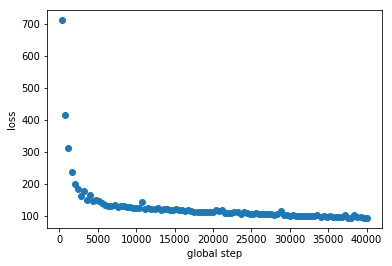

In [45]:
import matplotlib.pyplot as plt

loss = [evaluation['loss'] for evaluation in real_time_evaluations]
steps = [evaluation['global_step'] for evaluation in real_time_evaluations]

plt.scatter(x=steps, y=loss)
plt.xlabel('global step')
plt.ylabel('loss')
plt.show()

As we can see, the loss value doesn't exhibit a significant change in direction toward an increasing value (for readers who are actually running it, try multiple times if you don't get a diagram like the above). We can conclude that we get a pretty good model of our air pullutant data.

However, let's utilized our testing data to extract some statistical measurement of our data. Here, we use mean_absolute_error and median_absolute_error from scikit-learn.

In [46]:
pred = regressor.predict(
    input_fn=input_fn(X_test, num_epochs=1, shuffle=False))
predictions = np.array([p['predictions'][0] for p in pred])

print(mean_absolute_error(y_test, predictions))
print(median_absolute_error(y_test, predictions))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
0.286263731255
0.173508654143


As can be seen, we get very low mean absolute error and median absolute error. We can safely conclude that we ended up with a **good** model.

### Summary and references

1. Tensorflow https://github.com/tensorflow/tensorflow
2. scikit-learn http://scikit-learn.org/stable/
3. numpy http://www.numpy.org/
4. BeautifulSoup https://www.crummy.com/software/BeautifulSoup/
5. United States Environmental Protection Agency https://www.epa.gov/outdoor-air-quality-data/download-daily-data
6. 5 Statistical Methods For Forecasting Quantitative Time Series https://www.bistasolutions.com/resources/blogs/5-statistical-methods-for-forecasting-quantitative-time-series/
7. What is the difference between test set and validation set? https://stats.stackexchange.com/questions/19048/what-is-the-difference-between-test-set-and-validation-set
8. Introduction to TensorFlow Datasets and Estimators https://developers.googleblog.com/2017/09/introducing-tensorflow-datasets.html